# Foundations of Distributed and Large Scale Computing Optimization

#  Homework 2


Pierre Boyeau - MVA

# Reconstruction of DOSY NMR signals - Part I

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline

## I) Introduction

Goal: chemical mixture

We measure a signal $y$ in function of time $t$. We use the inverse Laplace transform to compute the associated diffusion distribution.

\begin{align*}
    y^m &=& \int \chi(T) \exp (-t^m T) dT
    \sim \sum \chi(T_n) \Delta T_n \exp (-t^m T)
\end{align*}

We consider the problem:

\begin{align*}
    y = Kx + w
\end{align*}

We are interested in determining mixture coefficients and their distribution, and thus consider an inverse problem

Thus, we consider the problem:

\begin{align*}
    \arg \min_{x \in \mathbb{R}^n} ||y - Kx||^2 + \beta g(x)
\end{align*}


## II) Generation of synthetic data



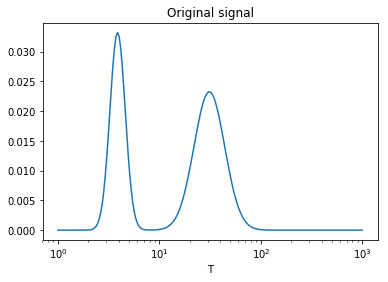

In [2]:
x = np.loadtxt('./x.txt') 

np.random.seed(seed=42)

Tmin = 1
Tmax = 1000
N = 200

M = 50
tmin = 0
tmax = 1.5
sigma = 1e-2

ns = np.arange(0, N)
Tn = Tmin * np.exp(-ns * np.log(Tmin/Tmax) / (N - 1))

plt.plot(Tn, x)
plt.xscale('log')
plt.xlabel('T')
plt.title('Original signal')

ms = np.arange(0, M)
tm = tmin + (ms / (M - 1)) * (tmax - tmin)

mat_prod = tm.reshape((-1, 1)) * Tn.reshape((1, -1))
K = np.exp(-mat_prod)
z = np.dot(K, x)
z_1 = z[0]

sigma=1e-3

Text(0,0.5,'y')

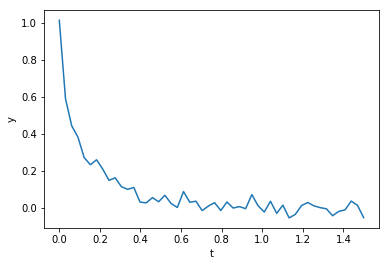

In [3]:
# Noisy data generation
mean = np.zeros(M)
cov = sigma * z_1 * np.eye(M)
w = np.random.multivariate_normal(mean=mean, cov=cov)

y = z + w
plt.plot(tm, y)
plt.xlabel('t')
plt.ylabel('y')

In [10]:
def normalize_err(x_original, x_reconst):
    return np.linalg.norm(x_original - x_reconst) / np.linalg.norm(x_original)

def plot_signals(x_rest):
    fig = plt.figure()
    plt.plot(Tn, x, label='Original Signal')
    plt.plot(Tn, x_rest, label='Reconstructed Signal')
    plt.legend()
    plt.xscale('log')
    plt.xlabel('T')
    return fig

x_origin = x.copy()

## 3) Comparison of regularization strategies

Recall that the problem writes as:

\begin{align*}
    \arg \min_{x \in \mathbb{R}^n} ||y - Kx||^2 + \beta g(x)
\end{align*}

### A) Smoothness prior

We first consider $g$ defined as:

\begin{align*}
    g: x \mapsto \frac{1}{2} || Dx ||^2
\end{align*}

The objective thus becomes $A(x) = \frac{1}{2}||y - Kx||^2 + \beta \frac{1}{2} || Dx ||^2$

Notice that $A(x) = \frac{1}{2}(Kx - y)^T(Kx - y) + \beta \frac{1}{2} x^T D^T D x$

$A$ is a sum of 2 coercive quadratic forms and of linear and constant terms. It will be **convex** and could be **strictly convex** as long as $K^TK$ and $D^TD$ are positive definite.


*Are those matrices positive definite?*:

$D^TD$ cannot be positive definite as any vector of ones is a proper vector of this matrice.

We can show by looking at the spectrum of $K$ that $K$ is, however, positive definite.

However if we suppose that $K^TK$ is strictly convex then $A$ becomes strictly convex by sum of a strictly convex function and of convex functions

Mimizing $A$ is tantamount to taking its gradient to $0$:

\begin{align*}
    A(x) = \frac{1}{2}(Kx - y)^T(Kx - y) + \beta \frac{1}{2} x^T D^T D x \\
    \Rightarrow \nabla A = K^T (Kx - y) + \beta D^TDx
\end{align*}
as $K^TK$ and $D^TD$ are trivially symmetrical

Hence:
\begin{align*}
    \nabla A = 0 &\Leftrightarrow
    (K^TK + \beta D^TD) x^* = K^T y \\
    & \Leftrightarrow x^* = (K^TK + \beta D^TD)^{-1}
    (K^T y)
\end{align*}

In [43]:
D = np.eye(N) - np.roll(np.eye(N), -1)
D[0, -1] = -1

Best beta: 14.508287784959395 Error: 0.7568782830990722


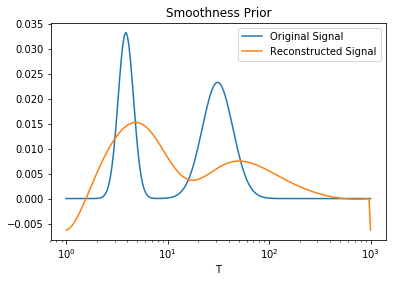

In [54]:
def reconstruct(beta):    
    y_out = np.dot(K.T, y)
    system = np.dot(K.T, K) + beta * np.dot(D.T, D)

    x_restored = np.linalg.solve(system, y_out)
    return x_restored

betas = np.geomspace(1e1, 1e5, 100)
errs = []
for beta in betas:
    x_restored = reconstruct(beta=beta)
    errs.append(normalize_err(x_origin, x_restored))

best_beta = betas[np.argmin(errs)]
# best_beta = 5e
x_restored = reconstruct(beta=best_beta)
_ = plot_signals(x_restored)
plt.title('Smoothness Prior')
print('Best beta: {} Error: {}'.format(best_beta, normalize_err(x, x_restored)))


### Smoothness prior + constrains

One issue of the previous model is that the reconstructed $x$ has negative values

For that purpose we add constrains that will enforce positivity.

However, we no longer have a closed form solution for this problem.

The problem writes as:

\begin{align*}
    \min_{x \in \mathbb{R}^N} f(x) + i_{[x_{min}, x_{max}]^N}(x) = \min_{x \in [x_{min}, x_{max}]^N} f(x)
\end{align*}
where f is in $\Gamma_0$ and is differentiable. This problem admits a solution because it is tantamount to minimizing a strict convex function of $\Gamma_0$ on a compact set. For that reason it admits one and one solution

We will use the projected gradient algorithm.

One thing we have to set though is a proper step-size for this algorithm, which is linked to the Lipschitz constant associated to the gradient of the differentiable part of the objective function. Notice that:

\begin{align*}
    ||\nabla f(x) - \nabla f(z)|| \leq ||\nabla^2 f||  \times ||x - z||
\end{align*}

Recall that the derivative of the differentiable part of the objective function is:

\begin{align*}
    K^T (Kx - y) + \beta D^TDx
\end{align*}

Determining the Lipschitz coefficient of this quantity is tantamount to finding the highest proper value of:

\begin{align*}
    K^T K + \beta D^TD
\end{align*}

In [44]:
# Etude du spectre
XMIN = x.min()
XMAX = x.max()

def projected_gradient(n_steps, beta, print_loss=False):
    def my_loss(my_x, my_beta):
        diff = K.dot(my_x) - y
        Dx = D.dot(my_x)
        loss = np.dot(diff.T, diff) + my_beta*np.dot(Dx.T, Dx)
        return 0.5*loss
    nu = np.abs(np.linalg.eigvals(K.T.dot(K) + beta * D.T.dot(D))).max()
    _, x_dim = K.shape
    sym_D = np.dot(D.T, D)
    gamma = 1.9 / nu
    lambd_step = 0.9 * (2.0 - gamma*nu/2.0)
    x_n = 0.02*np.ones(x_dim)    
    losses = []
    
    for my_iter in range(n_steps):
        x_prev = x_n.copy()
        
        grad = np.dot(K.T, (K.dot(x_prev) - y)) + beta * np.dot(sym_D, x_prev)
        aux = x_prev - gamma*grad
        
#         x_n = aux
        proj_aux = np.clip(aux, a_min=XMIN, a_max=XMAX)        
        x_n = x_n + lambd_step * (proj_aux - x_n) 
        losses.append(my_loss(x_n, beta))
        
        if np.abs(x_n - x_prev).max() <= 1e-16:
            print('Convergence in {} steps'.format(my_iter))
            if print_loss:
                plt.plot(losses)
            return x_n
        
    if print_loss:
        plt.plot(losses)
    print('No Convergence: ', np.abs(x_n - x_prev).max())
    return x_n

No Convergence:  2.685191791140795e-10
Best beta: 2.0 Error: 0.8925963790264075


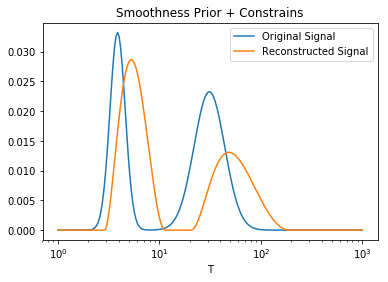

In [53]:
# betas = np.geomspace(1e3, 1e5, num=5)
# errs = []
# for beta in betas:
#     x_sol = projected_gradient(n_steps=50000, # gamma=GAMMA, 
#                                beta=beta)
#     errs.append(normalize_err(x, x_sol))
# best_beta = betas[np.argmin(errs)]
best_beta = 2e0

x_sol = projected_gradient(n_steps=50000,
                           beta=best_beta, print_loss=False)
_ = plot_signals(x_sol)
plt.title('Smoothness Prior + Constrains')
print('Best beta: {} Error: {}'.format(best_beta, normalize_err(x, x_sol)))

### Sparsity prior



This time, our objective function is the sum $h=f+g$ of a differentiable term $f$ and a non differentiable term $g$.

We will thus use a *Forward-Backward* procedure to optimize the objective function, with:

\begin{cases}
\nabla f(x) = K^T (Kx - y)\\
prox_{\gamma g}(\zeta) = sign(\zeta) (|\zeta| - \gamma)_+
\end{cases}


In [11]:
NU = np.linalg.eigvals(K.T.dot(K)).max()
NU = np.real(NU)

def prox_g(zeta, my_gamma, my_beta):
    diff = np.abs(zeta) - (my_gamma*my_beta)
    diff = np.maximum(diff, 0.0)
    return np.sign(zeta) * diff

def gradient_f(my_x):
    return K.T.dot(np.dot(K, my_x) - y)

class ForwardBackward:
    def __init__(self, grad_f, proxi_g, beta,
                 nu=NU, gamma=None, max_iter=10000,
                 lambda_factor=0.99):
        self.prox_g = proxi_g
        self.gradient_f = grad_f
        if gamma is None:
            self.gamma = 1.99 / NU
        else:
            self.gamma = gamma
        self.beta = beta
        self.lamd = lambda_factor * (2.0 - nu*self.gamma/2.0)
        assert self.gamma < 2./nu, 'Gamma value: {}, max possible value: {}'.format(gamma, 2.0/nu)
    
        self.max_iter = max_iter
        
    def optimize(self):
        _, x_dim = K.shape
        x_n = 0.02*np.ones(x_dim)
        for my_iter in range(self.max_iter):
            x_prev = x_n.copy()

            grad = self.gradient_f(x_n)
            zeta = x_n - self.gamma * grad
            x_n = x_n + self.lamd * (self.prox_g(zeta, 
                                                 my_gamma=self.gamma, 
                                                 my_beta=self.beta) - x_n)
            if np.abs(x_n - x_prev).max() <= 1e-16:
                print('Convergence in {} steps'.format(my_iter))
                return x_n
        print('No Convergence: ', np.abs(x_n - x_prev).max())
        return x_n

No Convergence:  3.716138091263159e-07
Best beta: 0.2 Error: 1.1813826644727092


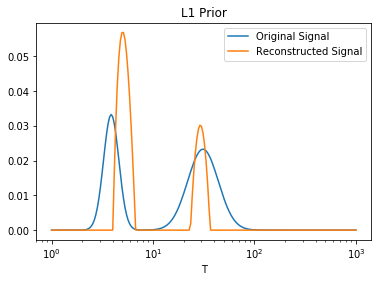

In [12]:
fb = ForwardBackward(grad_f=gradient_f, proxi_g=prox_g, 
                     beta=0.2, lambda_factor= 0.95, #  0.5, 
                     max_iter=70000)
x_fb = fb.optimize()
plot_signals(x_fb)
plt.title('L1 Prior')
print('Best beta: {} Error: {}'.format(0.2, normalize_err(x, x_fb)))

# Reconstruction of DOSY NMR signals - Part II

We consider this time new priors $g$ where g is this time the entropy.

$1$. Consider the entropy function defined as:

\begin{align*}
    ent(x) = \sum_{i=1}^N \phi(x^i)
\end{align*}
where $\phi$ is defined as:
\begin{align*}
    \phi(u) = 
    \begin{cases}
       u\log u \text{ if } u > 0\\ 
       0 \text{ if } u=0\\
       +\infty \text{ otherwise}
    \end{cases}
\end{align*}

$ent(x) \ne \infty$ as long as $x in \mathbb{R}^N$ so the function is proper. It is lower semi-continuous as we can easily notice that the epigraph of $\phi$ is closed, so $ent$ is lsc as sum of lsc functions.

Finally, on $\mathbb{R}_+^N$ is differentiable as long as $x$ does not have $0$ value and in such case we have that:
\begin{align*}
    \frac{\partial ent}{\partial x^i} = \log(x^i) + 1
\end{align*}

However, the function is not differentiable on $\mathbb{R}^N$

$2$. The objective function of problem (1) is in $\Gamma_0$ as sum of functions of $\Gamma_0$. Hence, this program has a solution. Notice then that $ent$ is strictly convex, so the overall objective function is strictly convex as a sum of a strictly convex function and a convex function. Hence, there exists an unique solution to (1)

$3$. We introduce the Lambert W-function defined as:
\begin{cases}
    f(W) := We^W \\
    W(f(W)) := W
\end{cases}


First of all, notice that $ent \in \Gamma_0(\mathbb{R}^N)$. Hence, its proximal is well defined and has value, as long as it is finite at a point x by:

\begin{align*}
    prox_{\gamma ent}(x)=
    \min_{y \in \mathbb{R}^N}\gamma \sum_i y_i \log y_i + \frac{1}{2} ||y-x||^2
\end{align*}

The term we need to minimize is a function $L$ on $y$ which is convex, continuous and differentiable. Finding its minimizers is tantamount to setting its gradient to $0$

\begin{align*}
    \frac{\partial L}{\partial y_i} = \gamma \log y_i + \gamma + y_i - x_i
\end{align*}

\begin{align*}
    \frac{\partial L}{\partial y_i} = 0 
    &\Leftrightarrow&
    \log y_i + \frac{y_i}{\gamma} = \frac{x_i}{\gamma} - 1 \\
    &\Leftrightarrow& 
    \frac{y_i}{\gamma} \exp \frac{y_i}{\gamma} = \gamma^{-1} \exp \{\frac{x_i}{\gamma} -1\}
    = \exp \{\frac{x_i}{\gamma} - 1 - \log \gamma\}
\end{align*}

Hence we see that if we denote as $y_i$ the proximal of the entropy, $y_i/\gamma$ is defined as the Lambert function of $f(x_i)= \frac{x_i}{\gamma} -1 - \log \gamma$

## Forward Backward Algorithm (Questions 5 and 6)

In [13]:
def safe_xlogx(my_x):
    assert (my_x >= 0.0).all()
    res = np.zeros(my_x.shape)
    not_null = res>0
    res[not_null] = res[not_null] * np.log(res[not_null])
    return res


def _hayley_method(logval):
    x = np.exp(logval)
    w = np.ones(len(logval))
    v = np.inf * w
    for iterat in range(10000):
        stop_crit = (np.abs(w - v) / np.abs(w)).max()
        if stop_crit < 1e-8:
            return w
        v = w.copy()
        exp_w = np.exp(w)
        f = w * exp_w - x
        w = w - f / (exp_w * (w + 1.0) - (w + 2.0) * f / (2.0 * w + 2.0))
    raise TimeoutError
    return w


def lambert(logval):
    """
    Solves W(e^logval)

    :param logval:
    :return:
    """
    res = np.zeros(logval.shape)
    exploding_cond = logval > 100
    if exploding_cond.any():
        exploding_terms = logval[exploding_cond] - np.log(logval[exploding_cond])
        res[logval > 100] = exploding_terms
    hayley_cond = (logval > -20.0) & (logval < 100)
    if hayley_cond.any():
        hayle_terms = _hayley_method(logval[hayley_cond])
        res[hayley_cond] = hayle_terms
    return res


def prox_ent(my_x, my_gamma, my_beta):
    coef = my_gamma * my_beta
    logval = (my_x / coef) - 1.0 - np.log(coef)
    res = lambert(logval=logval)
    yi = res * coef
    prox = yi
    return prox

$4$. 
Recall that the program writes as:

\begin{align*}
\min_{x\in \mathbb{R}^N} \frac{1}{2}||Kx-y||^2 + \beta ent(x)
\end{align*}

We can use a Forward-Backward procedure as our objective writes as $f+g$, were $f$ is differentiable and is the same that we used before and $g$ is in $\Gamma_0$ 

No Convergence:  6.710775731222363e-07
Error: 0.8096252607100375


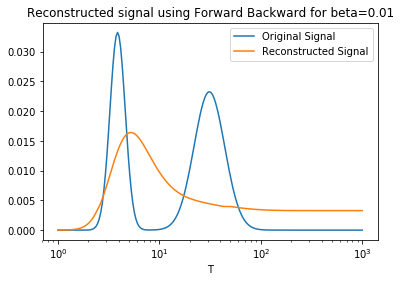

In [14]:
fb = ForwardBackward(beta=1e-2, lambda_factor=0.8, grad_f=gradient_f, proxi_g=prox_ent)
x_fb = fb.optimize()

_ = plot_signals(x_fb)
print('Error: {}'.format(normalize_err(x, x_fb)))
_ = plt.title('Reconstructed signal using Forward Backward for beta={}'.format(1e-2))

Without carefully choosing $\beta$, results are far from great.

Let's see if we can improve the reconstruction error by choosing a better regularization factor.

No Convergence:  2.2380285445537662e-07
Error: 1.0271397411899852


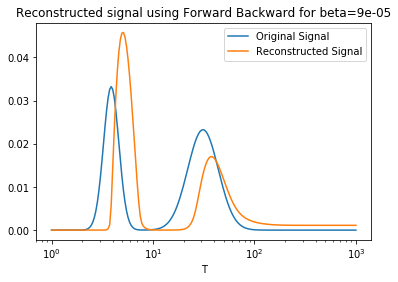

In [15]:
beta = 9e-5 
fb = ForwardBackward(beta=beta, lambda_factor=0.99, max_iter=40000,
                     grad_f=gradient_f, proxi_g=prox_ent)
x_fb = fb.optimize()

print('Error: {}'.format(normalize_err(x, x_fb)))
_ = plot_signals(x_fb)
_ = plt.title('Reconstructed signal using Forward Backward for beta={}'.format(beta))
# plt.savefig('sparsity_prior.png')

We can notice that a very small value of $\beta$ allows to obtain a interesting reconstruction, where we have successfull reconstructed the 2 modes of the function.
Thanks to the prior choice, we also ensure the positivity of the reconstructed signal.

## Douglas-Rachford Algorithm (Questions 5 and 6)

The program mentionned above can also be solved using a Douglas Rachford Algorithm. 

This algorithm requires the proximal expressions of $ent$ which we have already computed, and of $f(x) := ||Kx - y||^2$ which is very easy to compute and which is:

\begin{align*}
    prox_{\gamma f}(x) = (\gamma K^TK + I)^{-1}(x + \gamma K^T y)
\end{align*}

In [17]:
from tqdm import tqdm_notebook

class DouglasRachford:
    def __init__(self, beta_g, prox_f, prox_g, gamma, lambd, x_dim=x.shape, max_iter=10000):
        assert 0.0 <= lambd <= 2.0
        assert gamma >= 0.0

        self.beta_g = beta_g
        self.prox_f = prox_f
        self.prox_g = prox_g
        self.gamma = gamma
        self.lambd = lambd
        self.x_dim = x_dim
        self.max_iter = max_iter

    def optimize(self):
        x_n = 1e-2 * np.ones(self.x_dim)
        for my_iter in tqdm_notebook(range(self.max_iter)):
            x_prev = x_n.copy()
            y_n = self.prox_g(x_n, my_gamma=self.gamma, my_beta=self.beta_g)
            z_n = self.prox_f(2*y_n - x_n,
                              my_gamma=self.gamma)
            x_n = x_n + self.lambd * (z_n - y_n)

#             if np.abs(x_n - x_prev).max() <= 1e-20:
#                 print('Convergence in {} steps'.format(my_iter))
#                 return x_n
        print('No Convergence: ', np.abs(x_n - x_prev).max())
        return x_n

KTK = K.T.dot(K)

def prox_objective(my_x, my_gamma):
    right_term = my_x + my_gamma*(K.T.dot(y))
    my_mat = my_gamma*KTK + np.eye(KTK.shape[0])
    return np.linalg.solve(a=my_mat, b=right_term)

No Convergence:  1.1199374760906267e-14
Error: 0.8059131565440164


Text(0.5,1,'Reconstructed signal using Douglas Rachford for beta=0.01')

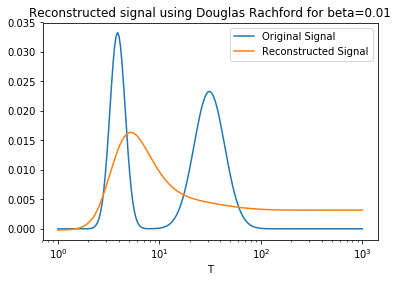

In [18]:
beta = 1e-2
dr = DouglasRachford(beta_g=beta, 
                     prox_f=prox_objective, prox_g=prox_ent, 
                     gamma=2e-3, lambd=1.5, max_iter=10000)
x_reconstructed = dr.optimize()


print('Error: {}'.format(normalize_err(x, x_reconstructed)))
_ = plot_signals(x_reconstructed)
plt.title('Reconstructed signal using Douglas Rachford for beta={}'.format(beta))

No Convergence:  1.1295672116490643e-06
Error: 0.8658894994014007


Text(0.5,1,'Reconstructed signal using Douglas Rachford for beta=0.0001')

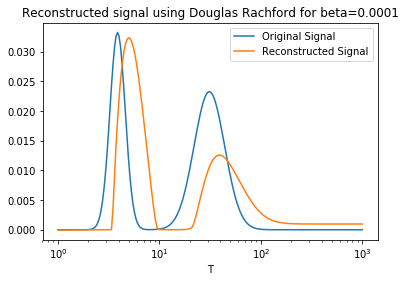

In [19]:
beta = 1e-4
dr = DouglasRachford(beta_g=beta, 
                     prox_f=prox_objective, prox_g=prox_ent, 
                     gamma=2e-3, lambd=1.5, max_iter=10000)
x_reconstructed = dr.optimize()

print('Error: {}'.format(normalize_err(x, x_reconstructed)))
_ = plot_signals(x_reconstructed)
plt.title('Reconstructed signal using Douglas Rachford for beta={}'.format(beta))

## Maximum  Entropy Regularization vs previous priors

Using Entropy is a good alternative to the previous regularization strategies we had (especially the smoothness + constrains prior, why gave the best results)

Without enforcing directly sparsity or positivity constrains, it allows us to get a properly regularized solution without too much efforts.

However, setting $\beta$ can be painful.

We can note that using Douglas Rachford on this task is a bad idea, as we do not use the fact that $x \mapsto ||Kx - y||^2$ is differentiable. Convergence is slower, and optimization parameters are difficult to tune, compared to a Forward Backward Strategy 

## New formulation solved using PPXA+

We have noticed that setting $\beta$ can be complicated to set. For this reason, we consider the minimum discrepancy problem:

\begin{align*}
    &\min_{x \in \mathbb{R}^N}ent(x) \\
    &s.t. ||Kx - y||^2 \leq \eta M \sigma^2
\end{align*}

This problem can be rewritten as:

\begin{align*}
    (X):&\min_{x \in \mathbb{R}^N}ent(x) + i_{B(y, \sigma \sqrt{M \eta})}(Kx)\\
    \Leftrightarrow &\min_{x \in \mathbb{R}^N}
    \sum_{i=1}^N  \phi(x^i) + i_{B(y, \sigma \sqrt{M \eta})}(Kx)\\
\end{align*}

We recognize here a particular formulation of Douglas Rachford by writting:

\begin{align*}
    (X) \Leftrightarrow \min_{x \in \mathbb{R}^N} g_1(L_1x) + g_2(L_2x)
\end{align*}
where:

\begin{align*}
\begin{cases}
    g_1 = ent \\
    g_2 = i_{B(y, \sigma \sqrt{M \eta})}
\end{cases}
\text{ and }
\begin{cases}
    L_1 = Id \\
    g_2 = K
\end{cases}
\end{align*}


The PPXA+ algorithm is particularly suited to solve this problem

Based on what we have already done, the only quantity we need to compute to apply PPXA+ is $prox_{\gamma g_2}$ which simply corresponds to the projection on $B(y, \sigma \sqrt{M \eta})$. We get that:

\begin{align*}
    prox_{\gamma g_2}(x_2) = 
    \begin{cases}
        y + \frac{\sigma \sqrt{M \eta}}{||x_2 - y||}(x_2 - y) \text{ if x_2 is outside the ball} \\
        x_2 = y + (x_2 - 1)
    \end{cases}
\end{align*}

That gives the unique formula:
\begin{align*}
    prox_{\gamma g_2}(x_2) = 
    y + 
    \min(\frac{\sigma \sqrt{M \eta}}{||x_2 - y||}, 1)(x_2 - y)
\end{align*}

In [21]:
class TwoWayXPPA:
    def __init__(self, g1_prox, g2_prox, l1, l2, gamma,
                 lambd, n_iter=10000):
        assert 0.0 <= lambd <= 2.0
        assert gamma >= 0.0

        self.g1_prox = g1_prox
        self.g2_prox = g2_prox
        self.l1 = l1
        self.l2 = l2
        self.gamma = gamma
        self.lambd = lambd
        self.n_iter = n_iter

        self.prefactor = np.linalg.inv(self.l1.T.dot(self.l1)
                                       + self.l2.T.dot(self.l2))

    def optimize(self, x0_1, x0_2):
        vn = self.prefactor.dot(self.adjoint_sums(x0_1, x0_2))
        xn_1 = x0_1
        xn_2 = x0_2
        for _ in tqdm_notebook(range(self.n_iter)):
            yn_1 = self.g1_prox(xn_1, my_gamma=self.gamma)
            yn_2 = self.g2_prox(xn_2, my_gamma=self.gamma)

            cn = self.prefactor.dot(self.adjoint_sums(yn_1, yn_2))
            new_dot_term = 2.0*cn - vn
            xn_1 = xn_1 + self.lambd * (self.l1.dot(new_dot_term) - yn_1)
            xn_2 = xn_2 + self.lambd * (self.l2.dot(new_dot_term) - yn_2)

            vn = vn + self.lambd * (cn - vn)

        return vn

    def adjoint_sums(self, a_1, a_2):
        return self.l1.T.dot(a_1) + self.l2.T.dot(a_2)

Error: 0.6670129135887508


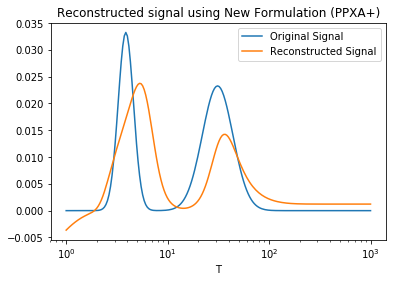

In [28]:
ETA = 0.1


def prox_ball_ind(my_x2, my_gamma, eta=ETA):
    y_cp = y.copy()
    min_part = np.minimum(1.0, sigma*np.sqrt(eta*M) / np.linalg.norm(my_x2 - y_cp))
    res = y + (my_x2 - y_cp)*min_part
#     print(np.linalg.norm(res - y_cp))
    return res

prox_g1 = lambda my_x1, my_gamma: prox_ent(my_x1, my_gamma, my_beta=1.0)
prox_g2 = lambda my_x2, my_gamma: prox_ball_ind(my_x2, my_gamma,
                                                eta=ETA)

x01 = 0.02*np.ones(N)
x02 = K.dot(x01)

ppxa = TwoWayXPPA(g1_prox=prox_g1, g2_prox=prox_g2, 
                  l1=np.eye(N), l2=K, 
                  gamma=1e0, lambd=0.1, n_iter=50000)
x_reco = ppxa.optimize(x0_1=x01, x0_2=x02)

_ = plot_signals(x_reco)
print('Error: {}'.format(normalize_err(x, x_reco)))
_ = plt.title('Reconstructed signal using New Formulation (PPXA+)')

This new formulation is yielding interesting results (in my opinion) for several reasons.

- First of all, parameters for the optimizer, and for the fitting/regularization tradeoff ($\eta$) are empirically easy to set
- The algorithm converges relatively fast
- Obtained reconstruction error is the best so far

That being said, we can see that reconstructed signal still has some flaws (no sparsity and negativity of $x$ in the beginning)